In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = "drive/MyDrive/ED_CNN/GTSRB_Final_Training_Images.zip"
directory_to_extract_to = "/content"

In [4]:
import zipfile
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [5]:
main_directory = "/content/GTSRB/Final_Training/Images"
train_data = []
train_labels = []
val_data = []
val_labels = []
test_data = []
test_labels = []
for i, folder in enumerate(os.listdir(main_directory)):
  df = pd.read_csv(main_directory + '/' + folder + "/" + "GT-" + folder +".csv")
  #print(len(df), len(os.listdir(main_directory + '/' + folder)))
  train_lim = int(0.6 * len(df))
  val_lim = int(0.8 * len(df))
  for idx, row in df.iterrows():
    row_values = str(row.iloc[0]).split(';')
    if idx < train_lim:
      train_data.append(main_directory + '/' + folder + '/' + row_values[0])
      train_labels.append(folder)
    elif idx < val_lim:
      val_data.append(main_directory + '/' + folder + '/' + row_values[0])
      val_labels.append(folder)
    else:
      test_data.append(main_directory + '/' + folder + '/' + row_values[0])
      test_labels.append(folder)
print(len(train_data), len(val_data), len(test_data))

23525 7842 7842


In [21]:
training = pd.DataFrame({"Filepath": train_data, "Target": train_labels})
validation = pd.DataFrame({"Filepath": val_data, "Target": val_labels})
testing = pd.DataFrame({"Filepath": test_data, "Target": test_labels})

7842

In [7]:
main_directory = "/content/GTSRB/Final_Training/Images"
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )
datagen1 = ImageDataGenerator(rescale=1./255, samplewise_center=True)

In [38]:
train_img = datagen.flow_from_dataframe(training, x_col="Filepath", y_col="Target", validate_filenames=False, target_size=[30, 30])
val_img = datagen1.flow_from_dataframe(validation, x_col="Filepath", y_col="Target", validate_filenames=False, target_size=[30, 30])
test_img = datagen1.flow_from_dataframe(testing, x_col="Filepath", y_col="Target", validate_filenames=False, target_size=[30, 30])
test_unibatch = datagen1.flow_from_dataframe(testing, x_col="Filepath", y_col="Target", validate_filenames=False, target_size=[30, 30], batch_size=len(testing))

Found 23525 non-validated image filenames belonging to 43 classes.
Found 7842 non-validated image filenames belonging to 43 classes.
Found 7842 non-validated image filenames belonging to 43 classes.
Found 7842 non-validated image filenames belonging to 43 classes.


In [25]:
def cnn_net(input_shape, num_classes):
  """
  CNN Model for identifying traffic signs
  """
  X_input = keras.layers.Input(shape=input_shape)
  X = keras.layers.Conv2D(filters=32, kernel_size =5, padding='same')(X_input)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.BatchNormalization()(X)
  X = keras.layers.Activation('relu')(X)
  
  X = keras.layers.MaxPool2D(pool_size=(3, 3), strides=[2, 2])(X)

  X = keras.layers.Conv2D(filters=64, kernel_size =3, padding='same')(X)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.BatchNormalization()(X)
  X = keras.layers.Activation('relu')(X)

  X = keras.layers.MaxPool2D(pool_size=[3, 3], strides=[2, 2])(X)

  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(128, activation='relu')(X)
  X = keras.layers.Dropout(0.1)(X)
  X = keras.layers.Dense(43, activation='softmax')(X)

  model = keras.models.Model(inputs = X_input, outputs= X, name="CNN_model")
  return model

In [26]:
cnn_model = cnn_net(input_shape=(30, 30, 3), num_classes=43)
cnn_model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        2432      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18

In [27]:
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=5)
checkpoint_path_cnn = "/content/drive/MyDrive/Models/cnn"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path_cnn, monitor="val_categorical_accuracy", save_best_only=True)

In [15]:
# Training
#history_cnn = cnn_model.fit(train_img, epochs=50, validation_data=val_img, callbacks=[early_stopping, model_checkpoint])
history_cnn = cnn_model.fit(train_img, epochs=20, validation_data=val_img)

Epoch 1/20
736/736 [==============================] - 53s 28ms/step - loss: 2.9160 - categorical_accuracy: 0.2300 - val_loss: 1.6082 - val_categorical_accuracy: 0.5173
Epoch 2/20
736/736 [==============================] - 20s 27ms/step - loss: 1.5354 - categorical_accuracy: 0.5110 - val_loss: 1.3537 - val_categorical_accuracy: 0.5601
Epoch 3/20
736/736 [==============================] - 20s 27ms/step - loss: 1.2311 - categorical_accuracy: 0.5912 - val_loss: 1.1664 - val_categorical_accuracy: 0.6257
Epoch 4/20
736/736 [==============================] - 20s 27ms/step - loss: 1.0971 - categorical_accuracy: 0.6294 - val_loss: 1.0606 - val_categorical_accuracy: 0.6543
Epoch 5/20
736/736 [==============================] - 19s 26ms/step - loss: 1.0335 - categorical_accuracy: 0.6481 - val_loss: 0.9063 - val_categorical_accuracy: 0.7035
Epoch 6/20
736/736 [==============================] - 19s 26ms/step - loss: 0.9283 - categorical_accuracy: 0.6857 - val_loss: 0.8961 - val_categorical_accuracy:

In [44]:
# Load the best CNN
loaded_cnn = keras.models.load_model(checkpoint_path_cnn)
loaded_cnn.evaluate(test_img)

246/246 [==============================] - 3s 12ms/step - loss: 0.5222 - categorical_accuracy: 0.8593


[0.5222090482711792, 0.8593471050262451]

In [16]:
# Test Performance
cnn_model.evaluate(test_img)

246/246 [==============================] - 2s 8ms/step - loss: 0.6487 - categorical_accuracy: 0.8179


[0.6487091183662415, 0.8179035782814026]

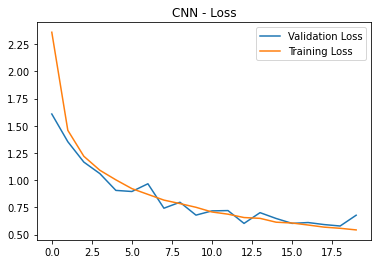

In [33]:
plt.plot(history_cnn.history["val_loss"], label="Validation Loss")
plt.plot(history_cnn.history["loss"], label="Training Loss")
plt.title("CNN - Loss")
plt.legend()

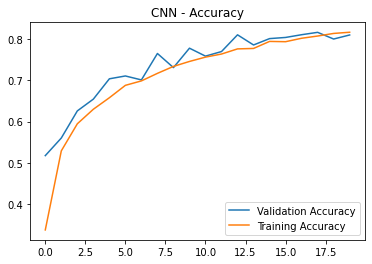

In [34]:
plt.plot(history_cnn.history["val_categorical_accuracy"], label="Validation Accuracy")
plt.plot(history_cnn.history["categorical_accuracy"], label="Training Accuracy")
plt.title("CNN - Accuracy")
plt.legend()

In [46]:
def SE_block(input_block, num_channels, ratio=16):
  """
  Squeeze and Excitation Block
  """
  X = keras.layers.GlobalAveragePooling2D()(input_block)
  X = keras.layers.Dense(num_channels//ratio, activation='relu')(X)
  X = keras.layers.Dense(num_channels, activation='sigmoid')(X)

  P = keras.layers.Multiply()([input_block, X])
  return P

In [47]:
def SE_net(input_shape, num_classes):
  """
  CNN with multiple Squeeze and Excitation Blocks
  """
  X_input = keras.layers.Input(shape=input_shape)
  X = keras.layers.Conv2D(filters=32, kernel_size =5, padding='same')(X_input)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.BatchNormalization()(X)
  X = keras.layers.Activation('relu')(X)

  X = SE_block(X, num_channels=32, ratio=16)

  X = keras.layers.MaxPool2D(pool_size=[3, 3], strides=[2, 2])(X)
  X = keras.layers.Conv2D(filters=64, kernel_size =3, padding='same')(X)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.BatchNormalization()(X)
  X = keras.layers.Activation('relu')(X)

  X = SE_block(X, num_channels=64, ratio=32)

  X = keras.layers.MaxPool2D(pool_size=[3, 3], strides=[2, 2])(X)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(128, activation='relu')(X)
  X = keras.layers.Dropout(0.1)(X)
  X = keras.layers.Dense(43, activation='softmax')(X)
  
  model = keras.models.Model(inputs = X_input, outputs= X, name='SE_Net')
  return model

In [48]:
se_net = SE_net(input_shape=(30, 30, 3), num_classes=43)
se_net.summary()

Model: "SE_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 32)   2432        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 30, 30, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 30, 30, 32)   128         dropout_3[0][0]                  
_____________________________________________________________________________________________

In [49]:
opt1 = keras.optimizers.Adam(learning_rate=0.001)
se_net.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
checkpoint_path_se_net = "/content/drive/MyDrive/Models/se_net"
early_stopping_se = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=5)
model_checkpoint_se = keras.callbacks.ModelCheckpoint(checkpoint_path_se_net, monitor="val_categorical_accuracy", save_best_only=True)

In [28]:
#se_net.fit(train_img, epochs=50, validation_data=val_img, callbacks=[early_stopping_se, model_checkpoint_se])
history_se = se_net.fit(train_img, epochs=20, validation_data=val_img)

Epoch 1/20
736/736 [==============================] - 20s 26ms/step - loss: 2.6889 - categorical_accuracy: 0.2662 - val_loss: 1.3336 - val_categorical_accuracy: 0.5933
Epoch 2/20
736/736 [==============================] - 19s 26ms/step - loss: 1.3518 - categorical_accuracy: 0.5668 - val_loss: 1.0492 - val_categorical_accuracy: 0.6635
Epoch 3/20
736/736 [==============================] - 19s 26ms/step - loss: 1.0666 - categorical_accuracy: 0.6422 - val_loss: 0.8809 - val_categorical_accuracy: 0.7294
Epoch 4/20
736/736 [==============================] - 19s 26ms/step - loss: 0.9248 - categorical_accuracy: 0.6907 - val_loss: 0.8610 - val_categorical_accuracy: 0.7161
Epoch 5/20
736/736 [==============================] - 19s 26ms/step - loss: 0.8180 - categorical_accuracy: 0.7193 - val_loss: 0.8891 - val_categorical_accuracy: 0.7108
Epoch 6/20
736/736 [==============================] - 19s 26ms/step - loss: 0.7510 - categorical_accuracy: 0.7428 - val_loss: 0.7530 - val_categorical_accuracy:

In [50]:
loaded_se = keras.models.load_model(checkpoint_path_se_net)

In [51]:
loaded_se.evaluate(test_img)

246/246 [==============================] - 3s 12ms/step - loss: 0.4022 - categorical_accuracy: 0.8666


[0.4021628797054291, 0.8666156530380249]

In [52]:
samples, y_true = test_unibatch[0]

In [53]:
y_pred = loaded_se.predict(samples)

In [54]:
y_pred_labels = np.array([keras.backend.argmax(sample).numpy() for sample in y_pred])
y_true_labels = np.array([keras.backend.argmax(sample).numpy() for sample in y_true])


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.21      0.35        42
           1       0.85      0.92      0.89       444
           2       0.87      0.70      0.77       450
           3       0.60      0.88      0.71       282
           4       0.92      0.99      0.95       396
           5       0.62      0.59      0.60       372
           6       0.76      0.98      0.85        84
           7       0.93      0.95      0.94       288
           8       0.95      0.74      0.83       282
           9       0.95      0.98      0.96       294
          10       0.99      0.99      0.99       402
          11       0.98      0.90      0.94       264
          12       1.00      0.95      0.97       420
          13       0.98      0.99      0.99       432
          14       1.00      0.90      0.95       156
          15       1.00      0.94      0.97       126
          16       1.00      0.99      0.99        84
          17       1.00    

In [29]:
se_net.evaluate(test_img)

246/246 [==============================] - 2s 8ms/step - loss: 0.4884 - categorical_accuracy: 0.8451


[0.48842790722846985, 0.8450650572776794]

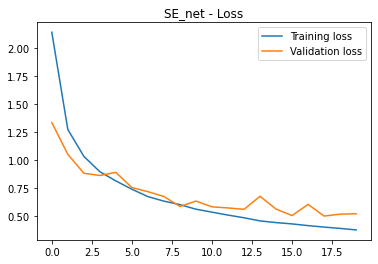

In [35]:
plt.plot(history_se.history["loss"], label = "Training loss")
plt.plot(history_se.history["val_loss"], label = "Validation loss")
plt.legend()
plt.title("SE_net - Loss")
plt.show()

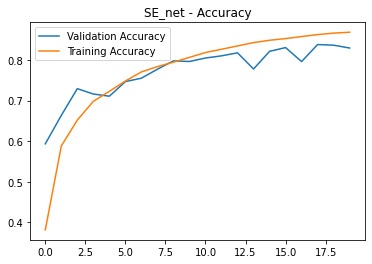

In [38]:
plt.plot(history_se.history["val_categorical_accuracy"], label = "Validation Accuracy")
plt.plot(history_se.history["categorical_accuracy"], label = "Training Accuracy")
plt.legend()
plt.title("SE_net - Accuracy")
plt.show()

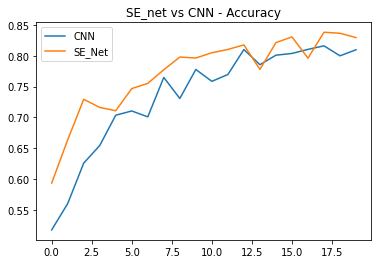

In [39]:
plt.plot(history_cnn.history["val_categorical_accuracy"], label = "CNN")
plt.plot(history_se.history["val_categorical_accuracy"], label = "SE_Net")
plt.legend()
plt.title("SE_net vs CNN - Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correct Label: 1
Predicted Label: 1


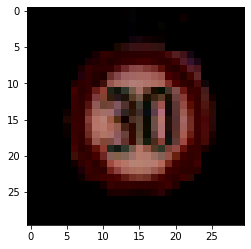

In [84]:
img_batch, label_batch = test_img[2]
img = img_batch[12]
label = keras.backend.argmax(label_batch[12]).numpy()
pred = loaded_se.predict(np.array([img,]))
pred_label = keras.backend.argmax(pred[0]).numpy()
plt.imshow(img)
print("Correct Label:", label)
print("Predicted Label:", pred_label)

In [116]:
model = loaded_cnn
model.layers[5]

In [127]:
# load the model
model = loaded_cnn
# redefine model to output right after the first hidden layer
model = keras.Model(inputs=model.inputs, outputs=model.layers[6].output)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        184

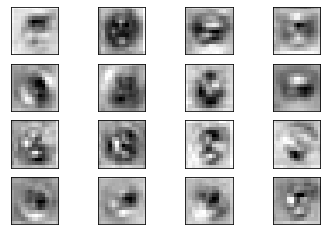

In [128]:
feature_maps = model.predict(np.array([img,]))
# plot the output from each block
square = 4
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()